In [ ]:
!pip install geopandas geodatasets rasterio contextily folium osmnx scikit-learn rasterstats matplotlib

In [3]:
!curl -L -o ./geographical-data.zip https://www.kaggle.com/api/v1/datasets/download/venkatkumar001/geographical-data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3458k  100 3458k    0     0  5980k      0 --:--:-- --:--:-- --:--:-- 5980k


In [4]:
!unzip /content/geographical-data.zip

Archive:  /content/geographical-data.zip
  inflating: Visualizing Geographical Data/world.cpg  
  inflating: Visualizing Geographical Data/world.dbf  
  inflating: Visualizing Geographical Data/world.prj  
  inflating: Visualizing Geographical Data/world.sbn  
  inflating: Visualizing Geographical Data/world.sbx  
  inflating: Visualizing Geographical Data/world.shp  
  inflating: Visualizing Geographical Data/world.shx  


In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import rasterio
from PIL import Image
from tqdm.auto import tqdm
import pandas as pd
import os

In [12]:
path = '/content/Visualizing Geographical Data/world.shp'
world = gpd.read_file(path)
world.dropna(subset=['FIPS'], inplace=True)
world.head()

,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ..."
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ..."
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39..."
3,AL,AL,ALB,8,Albania,2740,3153731,150,39,20.068,41.143,"POLYGON ((19.43621 41.02106, 19.45055 41.06, 1..."
4,AM,AM,ARM,51,Armenia,2820,3017661,142,145,44.563,40.534,"MULTIPOLYGON (((45.57305 40.63249, 45.52888 40..."


In [13]:
print("=== NUMERICAL COLUMNS SUMMARY ===")
numerical_cols = ['AREA', 'POP2005', 'LON', 'LAT'] # since others are integers
print(world[numerical_cols].describe())

print("\n=== CATEGORICAL COLUMNS SUMMARY ===")
categorical_cols = ['FIPS', 'ISO2', 'ISO3', 'NAME', 'REGION', 'SUBREGION'] # add Region and subregion
for col in categorical_cols:
    if col in world.columns:
        print(f"\n{col}:")
        print(f"  Unique values: {world[col].nunique()}")
        print(f"  Most common: {world[col].value_counts().head(3)}")

=== NUMERICAL COLUMNS SUMMARY ===
               AREA       POP2005         LON         LAT
count  2.430000e+02  2.430000e+02  243.000000  243.000000
mean   5.334666e+04  2.538255e+07   13.889848   16.232066
std    1.666644e+05  1.152952e+08   74.254319   27.012370
min    0.000000e+00  0.000000e+00 -178.131000  -80.446000
25%    5.800000e+01  1.682335e+05  -47.240000   -0.288500
50%    6.205000e+03  3.153731e+06   17.544000   16.286000
75%    3.567250e+04  1.288528e+07   50.876500   39.091500
max    1.638094e+06  1.312979e+09  179.219000   78.830000

=== CATEGORICAL COLUMNS SUMMARY ===

FIPS:
  Unique values: 243
  Most common: FIPS
AC    1
AG    1
AJ    1
Name: count, dtype: int64

ISO2:
  Unique values: 243
  Most common: ISO2
AG    1
DZ    1
AZ    1
Name: count, dtype: int64

ISO3:
  Unique values: 243
  Most common: ISO3
ATG    1
DZA    1
AZE    1
Name: count, dtype: int64

NAME:
  Unique values: 243
  Most common: NAME
Antigua and Barbuda    1
Algeria                1
Azerbaijan  

In [17]:
print(f"Current CRS: {world.crs}")

# Create a copy to avoid modifying original data
gdf_analysis = world.copy()

# Reproject to a suitable projected CRS for accurate measurements
# EPSG:6933 is a good global equal-area projection
gdf_projected = gdf_analysis.to_crs("EPSG:6933")

# Calculate geometric properties using the projected data
gdf_analysis['area_calculated_km2'] = gdf_projected.geometry.area / 1_000_000  # Convert to km²
gdf_analysis['bounding_box_area_km2'] = gdf_projected.geometry.envelope.area / 1_000_000

# For centroids, we can use the original CRS since we just want point locations
gdf_analysis['centroid'] = gdf_analysis.geometry.centroid
gdf_analysis['centroid_lon'] = gdf_analysis['centroid'].x
gdf_analysis['centroid_lat'] = gdf_analysis['centroid'].y

# Drop the temporary centroid column if you want
gdf_analysis = gdf_analysis.drop(columns=['centroid'])

print("Geometric properties calculated successfully!")
print(f"Sample calculated areas:")
display(gdf_analysis.head(3))

Current CRS: EPSG:4326
Geometric properties calculated successfully!
Sample calculated areas:


/tmp/ipython-input-342674424.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_analysis['centroid'] = gdf_analysis.geometry.centroid


,FIPS,ISO2,ISO3,UN,NAME,AREA,POP2005,REGION,SUBREGION,LON,LAT,geometry,area_calculated_km2,bounding_box_area_km2,centroid_lon,centroid_lat
0,AC,AG,ATG,28,Antigua and Barbuda,44,83039,19,29,-61.783,17.078,"MULTIPOLYGON (((-61.68667 17.02444, -61.73806 ...",5.434450e+02,1.943572e+03,-61.791128,17.280137
1,AG,DZ,DZA,12,Algeria,238174,32854159,2,15,2.632,28.163,"POLYGON ((2.96361 36.80222, 2.98139 36.80694, ...",2.317502e+06,4.060136e+06,2.632366,28.163357
2,AJ,AZ,AZE,31,Azerbaijan,8260,8352021,142,145,47.395,40.430,"MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...",8.591987e+04,1.857178e+05,47.532327,40.292220


In [18]:
print("=== Interactive Maps with Folium ===")
import folium

world = gdf_analysis.copy()
# Folium uses lat/lon (EPSG:4326), so ensure data is in geographic CRS
world_geo = world.to_crs(epsg=4326)

# Create base map centered on world
m = folium.Map(location=[20, 0], zoom_start=2)

# Add countries with popup info
folium.GeoJson(
    world_geo[['NAME', 'area_calculated_km2', 'geometry']].head(10),  # First 10 for performance
    tooltip=folium.GeoJsonTooltip(fields=['NAME', 'area_calculated_km2'],
                                 aliases=['Country:', 'Area (km²):']),
    style_function=lambda x: {'fillColor': 'lightblue', 'color': 'black'}
).add_to(m)

print("🌍 Interactive map created - scroll to explore!")
m  # Display in notebook

=== Interactive Maps with Folium ===
🌍 Interactive map created - scroll to explore!


=== Basemap Integration with Contextily ===


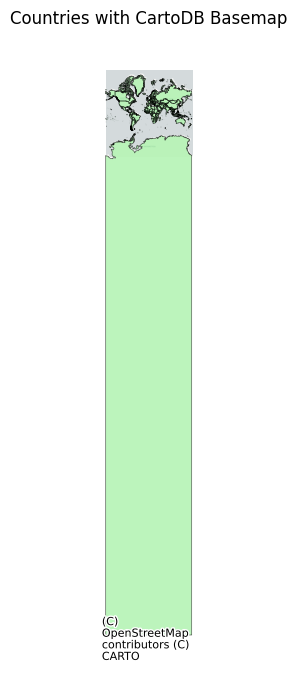

In [19]:
print("=== Basemap Integration with Contextily ===")
import contextily as ctx

# Contextily requires Web Mercator (EPSG:3857)
world_web = world.to_crs(epsg=3857)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot our data
world_web.plot(ax=ax, alpha=0.6, edgecolor='black',
               facecolor='lightgreen', linewidth=0.5)

# Add basemap - contextily automatically matches plot extent
ctx.add_basemap(ax, crs=world_web.crs, source=ctx.providers.CartoDB.Positron)

ax.set_title('Countries with CartoDB Basemap')
ax.set_axis_off()  # Hide axes for cleaner look
plt.show()

In [20]:
print("=== Working with Raster Data ===")
import rasterio
from rasterio.plot import show
import numpy as np

# Load sample Landsat imagery
try:
    raster_path = geodatasets.get_path("landsat_rgb")

    with rasterio.open(raster_path) as src:
        print(f"Raster info:")
        print(f"  CRS: {src.crs}")
        print(f"  Bounds: {src.bounds}")
        print(f"  Shape: {src.shape}")
        print(f"  Number of bands: {src.count}")

        # Read specific bands (Red, Green, Blue for true color)
        # Band numbering typically: 1=Blue, 2=Green, 3=Red, 4=NIR
        red = src.read(3)    # Band 3 = Red
        green = src.read(2)  # Band 2 = Green
        blue = src.read(1)   # Band 1 = Blue

        # Create RGB composite
        rgb = np.dstack((red, green, blue))

        # Normalize for display (satellite data often has high values)
        rgb_normalized = np.clip(rgb / 3000, 0, 1)

        # Plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.imshow(rgb_normalized)
        ax.set_title("Landsat RGB Composite")
        ax.set_axis_off()
        plt.show()

except Exception as e:
    print(f"Raster demo skipped: {e}")
    print("This often happens in online environments - works fine locally!")

=== Working with Raster Data ===
Raster demo skipped: name 'geodatasets' is not defined
This often happens in online environments - works fine locally!


=== OpenStreetMap Data with OSMnx ===


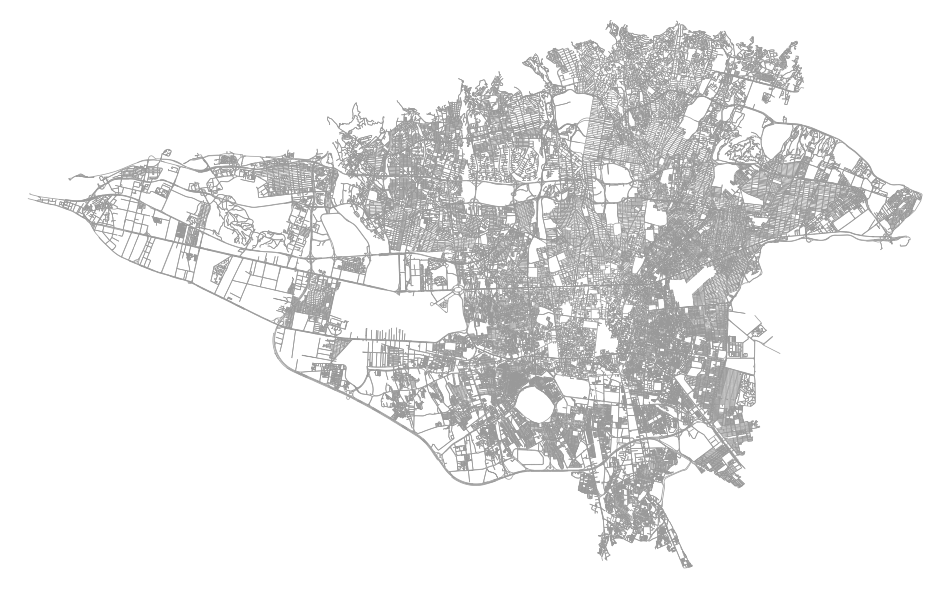

Number of nodes: 114092
Number of edges: 228367


In [21]:
print("=== OpenStreetMap Data with OSMnx ===")
import osmnx as ox

try:
    # Download and visualize street network
    print("Downloading Tehran street network...")

    # Get street network for Tehran
    graph = ox.graph_from_place("Tehran, Iran", network_type='drive', simplify=True)

    # Project to local CRS for accurate measurements
    graph_projected = ox.project_graph(graph)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ox.plot_graph(graph_projected, ax=ax, node_size=0, edge_linewidth=0.5)
    ax.set_title("Tehran Street Network")
    plt.show()

    # Basic network stats
    print(f"Number of nodes: {len(graph.nodes)}")
    print(f"Number of edges: {len(graph.edges)}")

except Exception as e:
    print(f"OSMnx demo skipped: {e}")
    print("This requires internet access - works fine with proper connectivity!")

Raster Time Series Use Cases:
- Climate Prediction: Temperature/precipitation forecasting
- Crop Yield Prediction: NDVI patterns → harvest estimates
- Disaster Monitoring: Flood/drought progression
- Urban Heat Islands: Temperature changes over time

OSM Time Series Use Cases:
- Urban Growth Modeling: Infrastructure development over years
- Network Evolution: Road network expansion
- Land Use Change: Commercial/residential area transitions
- Accessibility Analysis: How travel times change with new infrastructure

<br>

Start with Raster Data if you want:
- Traditional time series forecasting
- Environmental/climate applications
- High-frequency data (daily, weekly)
- Satellite/remote sensing applications

Consider OSM Data if you want:
- Urban planning applications
- Infrastructure development tracking
- Low-frequency changes (yearly)
- Combined with demographic/economic data

In [ ]:
# Example: Satellite imagery time series
import rasterio
import pandas as pd

# Multiple satellite passes over time
dates = ['2023-01-15', '2023-02-15', '2023-03-15']
ndvi_values = []

for date in dates:
    # Each date has its own raster file
    with rasterio.open(f'sentinel_ndvi_{date}.tif') as src:
        ndvi = src.read(1)  # NDVI band
        mean_ndvi = np.nanmean(ndvi)
        ndvi_values.append(mean_ndvi)

# Create time series
ts_df = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'mean_ndvi': ndvi_values
})

print("🌱 Vegetation Index Time Series:")
print(ts_df)

In [ ]:
import osmnx as ox
import pandas as pd
from datetime import datetime

# OSM data changes slowly, but you can track changes over years
years = [2015, 2018, 2021, 2024]
building_counts = []

for year in years:
    try:
        # Historical OSM data (requires special archives)
        buildings = ox.features_from_place('Manhattan, NYC',
                                         tags={'building': True})
        building_counts.append(len(buildings))
    except:
        # Fallback: simulate urban growth
        building_counts.append(1000 + year * 50)

# Urban development time series
urban_growth = pd.DataFrame({
    'year': years,
    'building_count': building_counts
})

print("🏗️ Urban Development Time Series:")
print(urban_growth)

In [ ]:
# Time series forecasting with raster data
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Example: Predict future NDVI based on historical patterns
def prepare_raster_time_series(raster_stack, dates, window_size=3):
    """Convert raster stack to ML-ready time series"""
    X, y = [], []

    for i in range(window_size, len(raster_stack)):
        # Use previous 'window_size' time steps to predict next
        features = raster_stack[i-window_size:i].flatten()
        target = raster_stack[i].mean()

        X.append(features)
        y.append(target)

    return np.array(X), np.array(y)

# This is perfect for: ARIMA, LSTM, Prophet, etc.